# Fine-Tuning for Lipophilicity

## Acknowledgment

**Most of the code is adapted fron the the work of [Xinhao Li](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00430-x) his [github](https://github.com/XinhaoLi74/MolPMoFiT) and [Marcos Santana](https://www.researchgate.net/publication/346223430_De_Novo_Design_and_Bioactivity_Prediction_of_SARS-CoV-2_Main_Protease_Inhibitors_Using_ULMFit) his [github](https://github.com/Marcosuff)**

In [ ]:
%%capture
!pip install fastai==2.1.4 
!pip install fastcore==1.3.1 

In [2]:
import fastai
print(fastai.__version__)

from fastai.text.all import *

2.1.4


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns
sns.set()
%matplotlib inline

In [ ]:
# http://moleculenet.ai/datasets-1

# https://en.wikipedia.org/wiki/Lipophilicity

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Lipophi_canon.csv")
df.head()

,CMPD_CHEMBLID,exp,smiles,canonical_smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)CSCC(=O)O
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl)sc2[nH]1
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)NCC#N)c1


In [ ]:
# number of SMILES strings
len(df)

4200

In [6]:
# Lipophilicity Data
df.rename(columns={'CMPD_CHEMBLID':'CMPD_CHEMBLID', "exp": "logD",
                   "smiles": "smiles","canonical_smiles":"SMILES"}, inplace=True)

df = df.drop(['CMPD_CHEMBLID', 'smiles'], axis=1)

df['canonical'] = 'yes'

In [ ]:
#take 20% and use 15% as validation set and 5% as test set for later
df['is_valid'] = False
val = np.random.choice(range(len(df)), size=int(len(df)*0.2), replace=False)

df.loc[val,'is_valid'] = True

In [ ]:
test_index = val[:int(len(val)/2)]
df_test = df.iloc[test_index]

df.drop(test_index, inplace=True)

# Data Augmentation

In [ ]:
%%capture
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
from rdkit import Chem
# original code by Xinhao Li
# code adapted from https://github.com/XinhaoLi74/MolPMoFiT/blob/master/notebooks/utils.py
def randomize_smiles(smiles):
    m = Chem.MolFromSmiles(smiles)
    ans = list(range(m.GetNumAtoms()))
    np.random.shuffle(ans)
    nm = Chem.RenumberAtoms(m,ans)
    return Chem.MolToSmiles(nm, canonical=False, isomericSmiles=True, kekuleSmiles=False)

def smiles_augmentation(df, N_rounds):
    dist_aug = {"SMILES": [] ,'logD':[],'canonical':[], 'is_valid':[]}

    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug['SMILES'].append(randomize_smiles(df.iloc[i].SMILES))
            # we will use Gaussian noise with sd=0.3
            dist_aug['logD'].append(df.iloc[i].logD + np.random.normal(loc=0.0, scale=0.3, size=1)[0])
            dist_aug['canonical'].append('no')
            dist_aug['is_valid'].append(df.iloc[i].is_valid)


    df_aug = pd.DataFrame.from_dict(dist_aug)
    
    #merge with original df
    df = pd.concat([df, df_aug], sort=False).reset_index(drop=True)
    #shuffle the data
    df = df.reindex(np.random.permutation(df.index))
    return pd.DataFrame.from_dict(df).drop_duplicates('SMILES')

In [ ]:
df_augment = smiles_augmentation(df, N_rounds=25)

In [ ]:
df_test_aug = smiles_augmentation(df_test, N_rounds=25)

In [ ]:
df_augment

,logD,SMILES,canonical,is_valid
23371,2.473107,CC[S+]([O-])c1ncccc1C1(O)CCN(CC23CC(c4ccccc42)...,no,False
82020,1.934550,C1CCCCC1[C@H](NC(=O)[C@H](C)NC)C(=O)N1[C@H](C(...,no,False
81142,1.332918,C1Cc2c(cccc2)C(=CCCNC)c2c1cccc2,no,False
71879,0.703099,c1c(-n2c(NS(=O)(=O)c3ccc(-c4cnco4)cc3)c(C(NC(C...,no,False
74640,1.041417,c1c(=O)n(C[C@@H](COC)O)c(=O)n(-c2ccc(Cl)c(C(NC...,no,False
...,...,...,...,...
16800,2.518377,c1(I)cc(I)c(O)c2c1cccn2,no,False
35120,2.986879,c1(F)c(-c2n(C(C)C)c(C)nc2)nc(Nc2ccc(N3CC(NC(C)...,no,False
48090,0.120395,n1c2ccccc2[nH]c(=O)c1NN,no,False
391,3.650000,COc1ccc(OC)c(-c2cccc3c(N)c(C(=O)NC(C)C)nnc23)c1,yes,True


In [ ]:
# df_augment.to_csv('/content/drive/My Drive/Colab Notebooks/Projects_Mol_ULMFiT/df_lip_aug.csv', index=False)
# df_test_aug.to_csv('/content/drive/My Drive/Colab Notebooks/Projects_Mol_ULMFiT/df_test_lip_aug.csv', index=False)

The original size of the Lipophilicity dataset is 4200 SMILES and after augmentation we have 92258 SMILES.

# Fine Tuning the LM in Lipophilicity data

In [7]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/df_lip_aug.csv")

df = df.drop(['canonical'], axis=1)

df.rename(columns={'SMILES':'Smiles', "logD": "logD",
                   "is_valid": "is_valid"}, inplace=True)

In [ ]:
# NUMBER OF SMILES AFTER AUGMENTATION
len(df)

92258

In [8]:
with open('/content/drive/My Drive/Colab Notebooks/vocab_11ep_FullAWDLSTM.pkl', 'rb') as fp:
    vocab_lm = pickle.load(fp) 

In [9]:
class MolTokenizer_v2():
  #source: https://github.com/Marcosuff/Marcosuff.github.io/tree/master/fastaiv2_works
  def tokenize_mols(self, t):
    pat = '(\[.*?\])' # Find special enviroments (e.g., [CH],[NH] etc)
    tokens = []
    t = t.replace('Br','L').replace('Cl','X') # Replace halogens
    atom_list = re.split(pat,t)
    for s in atom_list:
      if s.startswith('['):
        tokens.append(s)
      else:
        tokens += [x for x in list(s)]
    tokens = [x.replace('L','Br').replace('X','Cl') for x in tokens] # Decode halogens
    return [BOS] + tokens

  def __call__(self, items): return (self.tokenize_mols(t) for t in items)

In [10]:
d_block = DataBlock(blocks=TextBlock.from_df('Smiles',tok_text_col='Smiles',is_lm=True, # Pass is_lm = True since we are training a language model.
                                             tok=MolTokenizer_v2(), rules=[], vocab=vocab_lm), # Our tokenizer goes here and we define a minimum of 1
                    get_x=ColReader('Smiles'),
                    splitter=ColSplitter('is_valid'))

In [11]:
dls_lipo = d_block.dataloaders(df,bs=128,seq_len=40)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls_lipo.show_batch()

,text,text_
0,xxbos c 1 ( xxunk c 2 c c c c c 2 ) c ( xxunk c 2 c c c ( C 3 ( N ) C C C 3 ) c c 2 ) n c c,c 1 ( xxunk c 2 c c c c c 2 ) c ( xxunk c 2 c c c ( C 3 ( N ) C C C 3 ) c c 2 ) n c c (
1,) N ) n o c 2 C ) s c c n 1 xxbos c 1 ( C ) c c c ( C ( = O ) N ( C ( C C ) c 2 n (,N ) n o c 2 C ) s c c n 1 xxbos c 1 ( C ) c c c ( C ( = O ) N ( C ( C C ) c 2 n ( C
2,c 2 xxbos c 1 c ( N c 2 n c ( N ( c 3 c ( C ) c c c ( C O ) c 3 ) C ) c c n 2 ) c c,2 xxbos c 1 c ( N c 2 n c ( N ( c 3 c ( C ) c c c ( C O ) c 3 ) C ) c c n 2 ) c c (
3,) C C 3 ) c c 1 xxbos c 1 ( C ( N [C@@H] 2 C N 3 C C C 2 C C 3 ) = O ) s c ( xxunk c 2 c c c,C C 3 ) c c 1 xxbos c 1 ( C ( N [C@@H] 2 C N 3 C C C 2 C C 3 ) = O ) s c ( xxunk c 2 c c c c
4,c c 3 ) c ( C ) n ( C C ( = O ) O ) c 2 c c c 1 xxbos c 1 c c c ( [C@@H] ( C C N C ) O c,c 3 ) c ( C ) n ( C C ( = O ) O ) c 2 c c c 1 xxbos c 1 c c c ( [C@@H] ( C C N C ) O c 2
5,c 2 c c c c c 2 ) = N C 1 c 1 s c c c 1 xxbos c 1 c c c 2 c ( n n c ( C ( N C C C ),2 c c c c c 2 ) = N C 1 c 1 s c c c 1 xxbos c 1 c c c 2 c ( n n c ( C ( N C C C ) =
6,) c c ( O C ) c ( S ( N ( c 2 c c c c c 2 ) c 2 c c c c c 2 ) ( = O ) = O ) c 1,c c ( O C ) c ( S ( N ( c 2 c c c c c 2 ) c 2 c c c c c 2 ) ( = O ) = O ) c 1 xxbos
7,) c ( N C ( C c 3 c c ( F ) n c c 3 ) = O ) c 1 ) = O ) C ( C ) C C 2 xxbos C O C C,c ( N C ( C c 3 c c ( F ) n c c 3 ) = O ) c 1 ) = O ) C ( C ) C C 2 xxbos C O C C C
8,C ( c 2 c ( F ) c c c c 2 ) = N 1 xxbos c 1 c ( C C C ( = O ) O ) c ( C ) c ( / C =,( c 2 c ( F ) c c c c 2 ) = N 1 xxbos c 1 c ( C C C ( = O ) O ) c ( C ) c ( / C = C


### Load the Pre-trained model

In [ ]:
fn_path = Path('/content/fxa_finetune')
fn_path.mkdir()

In [ ]:
pretrained_vocab = '/content/drive/My Drive/Colab Notebooks/vocab_11ep_FullAWDLSTM.pkl'
pretrained_wgts = '/content/drive/MyDrive/Colab Notebooks/ChemLMModel_11ep_FullAWDLSTM.pth'
fnames = [pretrained_wgts,pretrained_vocab]

In [ ]:
# config = awd_lstm_lm_config.copy()
# config.update({'n_hid':512})

In [ ]:
learn_lipo = language_model_learner(dls_lipo, AWD_LSTM, pretrained=False,path=fn_path, #config=config,
                               drop_mult=0.7,metrics=[accuracy, Perplexity()]) #drop_mult=0.5 , 0.3

learn_lipo = learn_lipo.load_pretrained(wgts_fname=fnames[0],vocab_fname=fnames[1])

# learn_lipo.freeze()

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.17378008365631104)

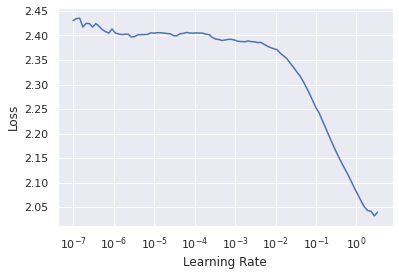

In [ ]:
learn_lipo.lr_find()

In [ ]:
# learn_lipo.freeze_to(-1)
learn_lipo.fit_one_cycle(n_epoch=3, lr_max=7e-2)  

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.167888,1.083871,0.632197,2.956100,03:50
1,1.150393,1.063516,0.638353,2.896536,03:52
2,1.135936,1.058993,0.639870,2.883466,03:52


In [ ]:
learn_lipo.unfreeze()
learn_lipo.fit_one_cycle(8, 1e-3) #(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.798378,0.751090,0.734918,2.119308,04:16
1,0.682006,0.687493,0.757569,1.988724,04:17
2,0.611149,0.647950,0.772761,1.911618,04:15
3,0.554845,0.634058,0.779236,1.885246,04:18
4,0.535012,0.625490,0.784199,1.869161,04:17
5,0.505073,0.624357,0.786774,1.867045,04:16
6,0.483635,0.625295,0.788505,1.868796,04:18
7,0.483924,0.626169,0.788821,1.870430,04:08


In [ ]:
learn_lipo.fit_one_cycle(4, 5e-5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.480204,0.627083,0.788909,1.872142,04:07
1,0.472163,0.626490,0.789134,1.871031,04:05
2,0.478766,0.626654,0.789360,1.871339,04:05
3,0.473438,0.626657,0.789350,1.871344,04:06


In [ ]:
learn_lipo.save('/content/drive/My Drive/Colab Notebooks/LM_1M_40seqLM_aug_lip_finetuned')
learn_lipo.save_encoder('/content/drive/My Drive/Colab Notebooks/LM_1M_40seqLM_aug_lip_finetuned_enc')

In [ ]:
learn_lipo.unfreeze()
learn_lipo.summary()

SequentialRNN (Input shape: ['128 x 40'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['128 x 40 x 1152',  1,852,416  True      
________________________________________________________________
LSTM                 ['128 x 40 x 1152',  5,317,632  True      
________________________________________________________________
LSTM                 ['128 x 40 x 400',   1,846,400  True      
________________________________________________________________
RNNDropout           128 x 40 x 400       0          False     
________________________________________________________________
RNNDropout           128 x 40 x 1152      0          False     
________________________________________________________________
RNNDropout           128 x 40 x 1152      0          False     
________________________________________________________________
Linear               128 x 40 x 240       96,240     True      
________________________________________________________

# QSAR Task using the Fine-tuned LM

In [12]:
with open('/content/drive/My Drive/Colab Notebooks/vocab_11ep_FullAWDLSTM.pkl', 'rb') as fp:
    vocab_lm = pickle.load(fp) 

In [13]:
d_block = DataBlock(
    blocks=(TextBlock.from_df('Smiles',tok_text_col='Smiles', seq_len=200,
                              tok=MolTokenizer_v2(), rules=[], vocab=vocab_lm), RegressionBlock),
                    get_x=ColReader('Smiles'),get_y=ColReader('logD'),
                    splitter=ColSplitter('is_valid')
                    ) 

In [14]:
dls_lip = d_block.dataloaders(df,bs=128)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls_lip.show_batch()

,text,text_
0,xxbos C ( N [C@H] ( C ( N [C@H] ( C ( = O ) N [C@@H] 1 C ( = O ) N C C ( = O ) N [C@@H] ( C C C N ) C ( = O ) N [C@@H] ( C C ( O ) = O ) C ( = O ) N [C@H] ( C ) C ( = O ) N [C@@H] ( C C ( = O ) O ) C ( = O ) N C C ( = O ) N [C@H] ( C O ) C ( = O ) N [C@@H] ( [C@H] ( C ) C C ( O ) = O ) C ( = O ) N [C@@H] ( C C ( c 2 c ( N ) c c c c 2 ) = O ) C ( = O ),-0.9756314754486084
1,xxbos C 1 N C ( = O ) [C@@H] ( N C ( = O ) [C@@H] ( N C ( [C@@H] ( N C ( [C@@H] ( N C ( = O ) C C C C C C C C C ) C c 2 c 3 c ( [nH] c 2 ) c c c c 3 ) = O ) C C ( = O ) N ) = O ) C C ( = O ) O ) [C@@H] ( C ) O C ( = O ) [C@H] ( C C ( = O ) c 2 c c c c c 2 N ) N C ( = O ) [C@H] ( [C@H] ( C ) C C ( O ) = O ) N C ( = O ) [C@@H] ( C O ) N C ( = O ) C,-1.3338708877563477
2,xxbos S ( = O ) ( N c 1 c c c ( N 2 C C N ( c 3 c c ( xxunk c 4 c ( xxunk c 5 c c c ( Cl ) c c 5 ) n ( C C ) c ( C ) c 4 C ( = O ) O ) c c c 3 ) C C 2 ) c c 1 ) ( = O ) c 1 c c ( S ( = O ) ( = O ) C ( F ) ( F ) F ) c ( N [C@@H] ( C S c 2 c c c c c 2 ) C C N 2 C C C ( O ) C C 2 ) c c 1,4.2752766609191895
3,xxbos S ( = O ) ( c 1 c ( N [C@@H] ( C S c 2 c c c c c 2 ) C C N 2 C C C ( O ) C C 2 ) c c c ( S ( N c 2 c c c ( N 3 C C N ( c 4 c c ( xxunk c 5 c ( C ( O ) = O ) c ( C ) n ( C C ) c 5 xxunk c 5 c c c ( Cl ) c c 5 ) c c c 4 ) C C 3 ) c c 2 ) ( = O ) = O ) c 1 ) ( C ( F ) ( F ) F ) = O,4.612443923950195
4,xxbos C ( C ) ( O C ( = O ) N [C@@H] ( c 1 c c c c c 1 ) [C@@H] ( O ) C ( = O ) O [C@@H] 1 C ( C ) = C 2 [C@@H] ( O ) C ( = O ) [C@@] 3 ( C ) [C@H] ( [C@H] ( O C ( c 4 c c c c c 4 ) = O ) [C@] ( O ) ( C 1 ) C 2 ( C ) C ) [C@@] 1 ( O C ( C ) = O ) [C@@H] ( C [C@@H] 3 O ) O C 1 ) ( C ) C . O . O . O,3.5616703033447266
5,xxbos O . c 1 ( [C@@H] ( [C@@H] ( O ) C ( = O ) O [C@@H] 2 C ( C ) = C 3 C ( C ) ( C ) [C@] ( O ) ( [C@@H] ( O C ( c 4 c c c c c 4 ) = O ) [C@H] 4 [C@@] ( C ) ( [C@@H] ( O ) C [C@H] 5 O C [C@@] 4 5 O C ( = O ) C ) C ( = O ) [C@@H] 3 O ) C 2 ) N C ( O C ( C ) ( C ) C ) = O ) c c c c c 1 . O . O,2.976428985595703
6,xxbos O [C@H] 1 C [C@H] 2 O C [C@@] 2 ( O C ( = O ) C ) [C@H] 2 [C@H] ( O C ( c 3 c c c c c 3 ) = O ) [C@@] 3 ( O ) C ( C ) ( C ) C ( = C ( C ) [C@@H] ( O C ( [C@@H] ( [C@H] ( c 4 c c c c c 4 ) N C ( O C ( C ) ( C ) C ) = O ) O ) = O ) C 3 ) [C@@H] ( O ) C ( = O ) [C@] 1 2 C . O . O . O,3.056368589401245
7,xxbos c 1 c c c ( S C [C@H] ( N c 2 c c c ( S ( = O ) ( = O ) N C ( c 3 c c c ( N 4 C C N ( C C 5 = C ( c 6 c c c ( Cl ) c c 6 ) C C C ( C ) ( C ) C 5 ) C C 4 ) c c 3 ) = O ) c c 2 S ( = O ) ( C ( F ) ( F ) F ) = O ) C C N 2 C C O C C 2 ) c c 1,1.3815550804138184
8,xxbos c 1 c ( S C [C@@H] ( C C N 2 C C O C C 2 ) N c 2 c c c ( S ( = O ) ( N C ( c 3 c c c ( N 4 C C N ( C C 5 = C ( c 6 c c c ( Cl ) c c 6 ) C C C ( C ) ( C ) C 5 ) C C 4 ) c c 3 ) = O ) = O ) c c 2 S ( C ( F ) ( F ) F ) ( = O ) = O ) c c c c 1,0.8359242081642151


In [ ]:
# config = awd_lstm_clas_config.copy()
# config.update({'n_hid':512})

In [15]:
reg_learner = text_classifier_learner(dls_lip, AWD_LSTM, pretrained=False, 
                                      drop_mult=0.5, metrics = [rmse])

In [16]:
reg_learner.load_encoder('/content/drive/My Drive/Colab Notebooks/LM_1M_40seqLM_aug_lip_finetuned_enc')

In [ ]:
reg_learner.lr_find()

In [ ]:
reg_learner.freeze_to(-1)
reg_learner.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,_rmse,time
0,1.096629,1.017841,1.008881,01:29
1,0.974936,0.938738,0.968885,01:31
2,0.862627,0.928447,0.963560,01:31


In [ ]:
reg_learner.freeze_to(-2)
reg_learner.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,_rmse,time
0,0.673947,0.771616,0.878417,01:37
1,0.559517,0.699027,0.836078,01:37
2,0.440511,0.671382,0.819379,01:36
3,0.428938,0.666769,0.816559,01:37


In [ ]:
reg_learner.freeze_to(-3)
reg_learner.fit_one_cycle(4, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,_rmse,time
0,0.377883,0.659043,0.811815,02:25
1,0.391298,0.654101,0.808765,02:25
2,0.358559,0.658032,0.811192,02:25
3,0.360139,0.652781,0.807949,02:25


In [ ]:
reg_learner.unfreeze()
reg_learner.fit_one_cycle(6, slice(5e-6/(2.6**4),5e-6))

epoch,train_loss,valid_loss,_rmse,time
0,0.349597,0.650235,0.806372,03:05
1,0.362664,0.654312,0.808896,03:06
2,0.348162,0.650776,0.806707,03:05
3,0.356657,0.659416,0.812045,03:06
4,0.367239,0.646869,0.804282,03:06
5,0.355233,0.655668,0.809733,03:05


In [17]:
reg_learner.unfreeze()
reg_learner.summary()

SequentialRNN (Input shape: ['128 x 212'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['128 x 68 x 1152',  1,852,416  True      
________________________________________________________________
LSTM                 ['128 x 68 x 1152',  5,317,632  True      
________________________________________________________________
LSTM                 ['128 x 68 x 400',   1,846,400  True      
________________________________________________________________
RNNDropout           128 x 68 x 400       0          False     
________________________________________________________________
RNNDropout           128 x 68 x 1152      0          False     
________________________________________________________________
RNNDropout           128 x 68 x 1152      0          False     
________________________________________________________________
BatchNorm1d          128 x 1200           2,400      True      
_______________________________________________________

In [ ]:
reg_learner.save('/content/drive/My Drive/Colab Notebooks/LM_1M_40seqLM_aug_lip_QSAR')

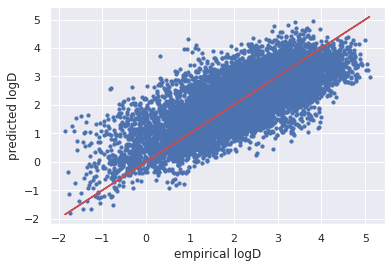

In [ ]:
pred, lbl = reg_learner.get_preds()

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(lbl, pred.squeeze(), s=10, c='b')
ax1.plot(lbl,lbl, c='r')
ax1.set(xlabel='empirical logD', ylabel='predicted logD')
plt.show()

Now let's see the generalization RMSE.

In [ ]:
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Projects_Mol_ULMFiT/df_test_lip_aug.csv")
df_test = df_test.drop(['canonical','is_valid'], axis=1)
df_test.rename(columns={'SMILES':'Smiles', "logD": "logD"}, inplace=True)

In [ ]:
dl_test = reg_learner.dls.test_dl(df_test, with_labels=True)
preds,targs, _ = reg_learner.get_preds(dl=dl_test, with_decoded=True)

In [ ]:
from sklearn.metrics import mean_squared_error 
mse = mean_squared_error(targs, preds)
rmse = math.sqrt(mse)
rmse

0.8121900700950101

# References:

[1] [Weininger D (1988) SMILES, a chemical language and information system. 1. Introduction to methodology and encoding rules. J Chem Inf Model 28:31–36. https ://doi.org/10.1021/ci000 57a005](https://pubs.acs.org/doi/10.1021/ci00057a005)

[2] [Li, Xinhao; Fourches, Denis (2020): SMILES Pair Encoding: A Data-Driven Substructure Tokenization Algorithm for Deep Learning. ChemRxiv. Preprint. https://doi.org/10.26434/chemrxiv.12339368.v1](https://chemrxiv.org/articles/SMILES_Pair_Encoding_A_Data-Driven_Substructure_Tokenization_Algorithm_for_Deep_Learning/12339368)

[3] [Li, X., Fourches, D. Inductive transfer learning for molecular activity prediction: Next-Gen QSAR Models with MolPMoFiT. J Cheminform 12, 27 (2020). https://doi.org/10.1186/s13321-020-00430-x](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00430-x)

[4] [Marcos Santana, Floriano Paes Silva. De Novo Design and Bioactivity Prediction of SARS-CoV-2 Main Protease Inhibitors Using ULMFit (2020)](https://www.researchgate.net/publication/346223430_De_Novo_Design_and_Bioactivity_Prediction_of_SARS-CoV-2_Main_Protease_Inhibitors_Using_ULMFit)

[5] [Howard J, Ruder S (2018) Universal language model fine-tuning for text
classification. http://arxiv .org/abs/1801.06146](https://arxiv.org/abs/1801.06146)

[6] [Smith LN (2018) A disciplined approach to neural network hyper-parameters:
Part 1: learning rate, batch size, momentum, and weight decay. http://arxiv .org/abs/1803.09820](https://arxiv.org/abs/1803.09820)